## cfos_batch_combination
The purpose of this notebook is to do some exploratory data analysis to try to visualize and ultimately understand what is causing the differences in fractional counts between c-Fos brains from different batches.

The main question we want to answer is: are the differences between brains from different batches larger than the differences between brains subject to different experimental conditions?

One way to try to answer this is to compare the fractional counts coming from large brain divisions between brains in these groups. 

In [5]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume
import edt
import seaborn as sns

%matplotlib inline

In [6]:
PCA_subset_file = '../data/202002_cfos_subset_PCA_groups.csv'
main_file = '../data/animals_counts.csv'
pivot_file = '../data/pivot.csv'
pma_segment_props_file = '../data/pma_segment_properties_info'
pma_ontology_json_file = '../data/PMA_ontology.json'
brain_divisions_file = '../data/developmentalregions.xlsx' # contains the telencephalon, mesencephalon, etc regions

In [7]:
with open(pma_ontology_json_file,'r') as infile:
    pma_ontology_dict = json.load(infile)

In [8]:
main_df = pd.read_csv(main_file)
main_df

,Brain,Condition,experiment,Peripeduncular nucleus,Parabigeminal nucleus,Pedunculopontine nucleus,"Substantia nigra, compact part",Inferior colliculus,"Midbrain reticular nucleus, retrorubral area",Nucleus sagulum,...,external medullary lamina of the thalamus,genu of corpus callosum,inferior cerebellar peduncle,commissural branch of stria terminalis,dorsal spinocerebellar tract,cerebellar commissure,genu of the facial nerve,direct tectospinal pathway,cuneate fascicle,pyramidal decussation
0,dadult_pc_crus1_8,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,0,0,26,50,4,0,...,0,0,0,0,0,0,0,0,0,0
1,dadult_pc_crus1_9,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,1,2,0,9,6,4,...,0,0,0,0,0,0,0,0,0,0
2,dadult_pc_crus1_5,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,9,13,10,46,23,8,...,0,0,0,0,0,0,0,0,0,0
3,dadult_pc_crus1_6,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,0,7,33,8,6,68,...,0,0,0,0,0,0,0,0,0,0
4,dadult_pc_crus1_2,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0,2,1,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,an026,acquisition_day2,ymaze_learning,4,5,108,88,1,1,24,...,2,4,15,2241,1,86,1,0,0,0
154,an027,acquisition_day2,ymaze_learning,23,11,529,91,7,173,20,...,7,103,58,3292,0,7,0,0,0,0
155,an028,acquisition_day2,ymaze_learning,13,4,570,30,0,280,129,...,5,298,43,3013,31,5,0,0,0,0
156,an029,acquisition_day2,ymaze_learning,29,2,51,0,1,1,8,...,2,20,0,2055,0,0,0,0,0,0


In [9]:
# Make a summed column
main_df['sumcounts'] = main_df.iloc[:,3:].sum(axis=1)

This dataframe has the brain, condition, experiment (aka batch) and then c-fos cell counts in each PMA brain region

Let's strip out a single row which corresponds to a single brain to look at.

In [10]:
test_brain_series = main_df[main_df['experiment']=='202002_cfos'].iloc[0]
test_brain_series

Brain                         an5_cno_injection_only
Condition                         cno_injection_only
experiment                               202002_cfos
Peripeduncular nucleus                             0
Parabigeminal nucleus                            730
                                       ...          
genu of the facial nerve                           0
direct tectospinal pathway                         0
cuneate fascicle                                   0
pyramidal decussation                              0
sumcounts                                    3589704
Name: 76, Length: 668, dtype: object

Now let's pick a large parent region and sum up counts in that region and all its progeny regions.

Need a graph function to do this

In [11]:
def get_progeny(dic,parent_structure,progeny_list):
    """ 
    ---PURPOSE---
    Get a list of all progeny of a structure name.
    This is a recursive function which is why progeny_list is an
    argument and is not returned.
    ---INPUT---
    dic                  A dictionary representing the JSON file 
                         which contains the ontology of interest
    parent_structure     The structure
    progeny_list         The list to which this function will 
                         append the progeny structures. 
    """
    name = dic.get('name')
    children = dic.get('children')
    if name == parent_structure:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,parent_structure=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,parent_structure=parent_structure,progeny_list=progeny_list)
    return

In [12]:
def get_fractional_counts(soi,series,debug=False):
    """ Get the fractional counts in a region
    and all of its descendent regions.
    
    ---INPUT---
    soi    region name of interest
    seires pandas series representing a row (single brain) from the main dataframe
    ---OUTPUT---
    total  the total number of summed
    """
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        if debug:
            print(f"{soi} is in dataframe!")
        total+=series[soi]
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            if debug:
                print(f"{progen} is in dataframe!")
            count = int(series[progen])
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total/series['sumcounts']

In [13]:
# Verify that this function correctly calculates the total counts when given the root
get_fractional_counts("root",test_brain_series)

1.0

In [15]:
test_brain_series['sumcounts'] # this is the total number of counts for this brain

3589704

In [17]:
# the fraction of counts in the Cerebral cortex and child regions
get_fractional_counts("Cerebral cortex",test_brain_series) 

0.5173242696333736

OK so now we have a way to get the fractional counts from any region, regardless of whether it is in the dataframe

Now what we want to do is figure out the fractional counts coming from several main brain areas for each brain in a batch and make a boxplot

In [18]:
# see contents of brain_divisions_file
brain_division_dict = {
    'Telencephalon':
    ["Anterior amygdalar area","Basolateral amygdalar nucleus",
"Central amygdalar nucleus","Cortical amygdalar area","Intercalated amygdalar nucleus","Lateral amygdalar nucleus",
"Posterior amygdalar nucleus","Somatomotor areas","Somatosensory areas","Gustatory areas","Visceral area",
"Auditory areas","Visual areas","Anterior cingulate area","Prelimbic area","Infralimbic area","Orbital area",
"Retrosplenial area","Posterior parietal association areas","Temporal association areas","Perirhinal area",
"Ectorhinal area","Hippocampal region","Retrohippocampal region","Endopiriform nucleus","Caudoputamen",
"Nucleus accumbens","Fundus of striatum","Lateral septal nucleus","Septofimbrial nucleus",
"Septohippocampal nucleus","Pallidum"],
    'Diencephalon':
    ["Ventral anterior-lateral complex of the thalamus","Ventral medial nucleus of the thalamus",
"Ventral posterolateral nucleus of the thalamus","Ventral posterolateral nucleus of the thalamus, parvicellular part",
"Ventral posteromedial nucleus of the thalamus","Ventral posteromedial nucleus of the thalamus, parvicellular part",
"Posterior triangular thalamic nucleus","Subparafascicular nucleus","Subparafascicular area",
"Lateral posterior nucleus of the thalamus","Posterior complex of the thalamus","Anteroventral nucleus of thalamus",
"Anteromedial nucleus","Anterodorsal nucleus","Interanteromedial nucleus of the thalamus",
"Interanterodorsal nucleus of the thalamus","Lateral dorsal nucleus of thalamus","Intermediodorsal nucleus of the thalamus",
"Submedial nucleus of the thalamus","Parataenial nucleus","Paraventricular nucleus of the thalamus",
"Nucleus of reuniens","Rhomboid nucleus","Central medial nucleus of the thalamus","Paracentral nucleus",
"Central lateral nucleus of the thalamus","Parafascicular nucleus","Reticular nucleus of the thalamus",
"Medial habenula","Lateral habenula","Arcuate hypothalamic nucleus","Anterodorsal preoptic nucleus",
"Anteroventral preoptic nucleus","Anteroventral periventricular nucleus","Medial preoptic area",
"Posterodorsal preoptic nucleus","Parastrial nucleus","Periventricular hypothalamic nucleus, posterior part",
"Periventricular hypothalamic nucleus, preoptic part","Subparaventricular zone","Suprachiasmatic nucleus",
"Fundus of striatum","Mammillary body","Median preoptic nucleus","Dorsal premammillary nucleus",
"Ventral premammillary nucleus","Lateral hypothalamic area","Lateral preoptic area","Retrochiasmatic area",
"Subthalamic nucleus","Tuberal nucleus","Zona incerta","Median eminence"],
    'Mesencephalon':
    ["Superior colliculus, sensory related","Nucleus of the brachium of the inferior colliculus",
"Nucleus sagulum","Parabigeminal nucleus","Substantia nigra, reticular part","Ventral tegmental area",
"Midbrain reticular nucleus, retrorubral area","Superior colliculus, motor related","Periaqueductal gray",
"Pretectal region","Cuneiform nucleus","Red nucleus","Oculomotor nucleus","Paratrochlear nucleus",
"Ventral tegmental nucleus","Anterior tegmental nucleus","Substantia nigra, compact part",
"Pedunculopontine nucleus","Midbrain raphe nuclei"],
    'Metencephalon':
    ["Parabrachial nucleus","Superior olivary complex","Barrington's nucleus","Dorsal tegmental nucleus",
"Posterodorsal tegmental nucleus","Pontine central gray","Pontine gray","Pontine reticular nucleus, caudal part",
"Supragenual nucleus","Supratrigeminal nucleus","Tegmental reticular nucleus","Motor nucleus of trigeminal",
"Laterodorsal tegmental nucleus","Nucleus incertus","Pontine reticular nucleus","Nucleus raphe pontis",
"Subceruleus nucleus","Sublaterodorsal nucleus"]
                      }

In [19]:
%%time
# Let's calculate the fractional counts from each of these large brain divisions for the single test brain

for division in brain_division_dict:
    subregions = brain_division_dict[division]
    frac_counts = [get_fractional_counts(soi,test_brain_series) for soi in subregions]
    print(division,sum(frac_counts))

Telencephalon 0.541149075244087
Diencephalon 0.10891650119341317
Mesencephalon 0.1261023192998643
Metencephalon 0.0
CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 90.3 ms


In [20]:
# That is super quick for one brain! Let's do this for all brains in the 202002 batch
batch_mask = main_df['experiment']=='202002_cfos'
condition_mask = main_df['Condition'] == 'CNOnCrusILT'
comb_mask = np.logical_and(batch_mask,condition_mask)
batch_2020_CNOCrusILT_df = main_df[comb_mask]
batch_2020_CNOCrusILT_df


,Brain,Condition,experiment,Peripeduncular nucleus,Parabigeminal nucleus,Pedunculopontine nucleus,"Substantia nigra, compact part",Inferior colliculus,"Midbrain reticular nucleus, retrorubral area",Nucleus sagulum,...,genu of corpus callosum,inferior cerebellar peduncle,commissural branch of stria terminalis,dorsal spinocerebellar tract,cerebellar commissure,genu of the facial nerve,direct tectospinal pathway,cuneate fascicle,pyramidal decussation,sumcounts
85,an15_crus1_left,CNOnCrusILT,202002_cfos,0,519,11979,204,543318,816,985,...,0,0,0,0,0,0,0,0,0,2649288
86,an16_crus1_left,CNOnCrusILT,202002_cfos,0,473,3901,415,43955,903,486,...,0,0,0,0,0,0,0,0,0,1630650
87,an17_crus1_left,CNOnCrusILT,202002_cfos,0,633,2530,292,14524,417,799,...,0,0,0,0,0,0,0,0,0,1586273
90,an1_crus1_left,CNOnCrusILT,202002_cfos,0,192,4223,508,287338,979,297,...,0,0,0,0,0,0,0,0,0,1452074
101,an2_crus1_lat,CNOnCrusILT,202002_cfos,0,746,10447,848,10701,2244,510,...,0,0,0,0,0,0,0,0,0,1557110
109,an5_crus1_left,CNOnCrusILT,202002_cfos,0,197,5497,882,10294,200,561,...,0,0,0,0,0,0,0,0,0,1939169
110,an6_crus1_left,CNOnCrusILT,202002_cfos,0,848,11125,821,525184,1631,1422,...,0,0,0,0,0,0,0,0,0,2481931
111,an7_crus1_left,CNOnCrusILT,202002_cfos,0,209,6259,573,421998,886,365,...,0,0,0,0,0,0,0,0,0,2191883
112,an8_crus1_left,CNOnCrusILT,202002_cfos,0,457,14950,810,548911,2108,697,...,0,0,0,0,0,0,0,0,0,2456763
113,an9_crus1_left,CNOnCrusILT,202002_cfos,0,206,7179,1267,462464,1880,414,...,0,0,0,0,0,0,0,0,0,2570593


In [21]:
# make a dictionary where keys are Brain names and values are dictionaries mapping brain division to fractional counts
batch_frac_counts_dict = {}
for index,brain_series in batch_2020_CNOCrusILT_df.iterrows():
    brain = brain_series['Brain']
    batch_frac_counts_dict[brain] = {}
    for division in brain_division_dict:
        subregions = brain_division_dict[division]
        frac_counts = [get_fractional_counts(soi,brain_series) for soi in subregions]
        batch_frac_counts_dict[brain][division] = sum(frac_counts)
batch_frac_counts_dict

{'an15_crus1_left': {'Telencephalon': 0.4392606617325108,
  'Diencephalon': 0.04826768550644551,
  'Mesencephalon': 0.12171081437729685,
  'Metencephalon': 0.0},
 'an16_crus1_left': {'Telencephalon': 0.6185582436451721,
  'Diencephalon': 0.06784227148683039,
  'Mesencephalon': 0.07332352129518904,
  'Metencephalon': 0.0},
 'an17_crus1_left': {'Telencephalon': 0.5564924826937104,
  'Diencephalon': 0.10863577706989908,
  'Mesencephalon': 0.06123599153487452,
  'Metencephalon': 0.0},
 'an1_crus1_left': {'Telencephalon': 0.49094880839406263,
  'Diencephalon': 0.05675468330126427,
  'Mesencephalon': 0.11628401858307497,
  'Metencephalon': 0.0},
 'an2_crus1_lat': {'Telencephalon': 0.5890174746806586,
  'Diencephalon': 0.08610695455041711,
  'Mesencephalon': 0.10451991188804899,
  'Metencephalon': 0.0},
 'an5_crus1_left': {'Telencephalon': 0.5983104102839928,
  'Diencephalon': 0.07217576188563246,
  'Mesencephalon': 0.07099071818907997,
  'Metencephalon': 0.0},
 'an6_crus1_left': {'Telencepha

(10, 4)


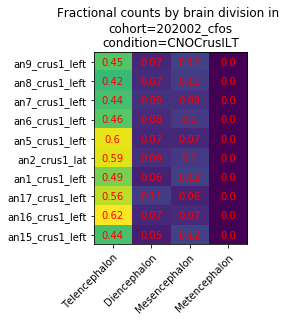

In [22]:
# now make a heatmap of counts for each animal in the batch. 
brains = list(batch_2020_CNOCrusILT_df['Brain'])
divisions = list(brain_division_dict.keys())

harvest = np.zeros([len(brains),len(divisions)])
for ii,brain in enumerate(brains):
    brain_dict = batch_frac_counts_dict[brain]
    for jj,division in enumerate(divisions):
        frac_count = brain_dict[division]
        harvest[ii][jj] = frac_count
print(harvest.shape)
fig, ax = plt.subplots()
im = ax.imshow(harvest,aspect=0.5)

# We want to show all ticks...
ax.set_xticks(np.arange(len(divisions)))
ax.set_yticks(np.arange(len(brains)))
# ... and label them with the respective list entries
ax.set_xticklabels(divisions)
ax.set_yticklabels(brains)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(divisions)):
    for j in range(len(brains)):
        text = ax.text(i, j, round(harvest[j, i],2),
                       ha="center", va="center", color="red")
# ax.text(3,9,'test',ha="center", va="center", color="w")
fig.tight_layout()
ax.set_ylim(-0.5, len(brains)-0.5)

ax.set_title("Fractional counts by brain division in \ncohort=202002_cfos\ncondition=CNOCrusILT")
plt.savefig('../figs/test.png')

Now let's figure out how to make the box plots so we can show the spread from a single cohort 

In [35]:
batch_frac_counts_dict

{'an15_crus1_left': {'Telencephalon': 0.4392606617325108,
  'Diencephalon': 0.04826768550644551,
  'Mesencephalon': 0.12171081437729685,
  'Metencephalon': 0.0},
 'an16_crus1_left': {'Telencephalon': 0.6185582436451721,
  'Diencephalon': 0.06784227148683039,
  'Mesencephalon': 0.07332352129518904,
  'Metencephalon': 0.0},
 'an17_crus1_left': {'Telencephalon': 0.5564924826937104,
  'Diencephalon': 0.10863577706989908,
  'Mesencephalon': 0.06123599153487452,
  'Metencephalon': 0.0},
 'an1_crus1_left': {'Telencephalon': 0.49094880839406263,
  'Diencephalon': 0.05675468330126427,
  'Mesencephalon': 0.11628401858307497,
  'Metencephalon': 0.0},
 'an2_crus1_lat': {'Telencephalon': 0.5890174746806586,
  'Diencephalon': 0.08610695455041711,
  'Mesencephalon': 0.10451991188804899,
  'Metencephalon': 0.0},
 'an5_crus1_left': {'Telencephalon': 0.5983104102839928,
  'Diencephalon': 0.07217576188563246,
  'Mesencephalon': 0.07099071818907997,
  'Metencephalon': 0.0},
 'an6_crus1_left': {'Telencepha

In [36]:
frac_counts_by_division = []

for brain in batch_frac_counts_dict:
    division_dict = {'Brain':brain}
    for division in batch_frac_counts_dict[brain]:
        division_dict[division] = batch_frac_counts_dict[brain][division]
    frac_counts_by_division.append(division_dict)
frac_counts_by_division

[{'Brain': 'an15_crus1_left',
  'Telencephalon': 0.4392606617325108,
  'Diencephalon': 0.04826768550644551,
  'Mesencephalon': 0.12171081437729685,
  'Metencephalon': 0.0},
 {'Brain': 'an16_crus1_left',
  'Telencephalon': 0.6185582436451721,
  'Diencephalon': 0.06784227148683039,
  'Mesencephalon': 0.07332352129518904,
  'Metencephalon': 0.0},
 {'Brain': 'an17_crus1_left',
  'Telencephalon': 0.5564924826937104,
  'Diencephalon': 0.10863577706989908,
  'Mesencephalon': 0.06123599153487452,
  'Metencephalon': 0.0},
 {'Brain': 'an1_crus1_left',
  'Telencephalon': 0.49094880839406263,
  'Diencephalon': 0.05675468330126427,
  'Mesencephalon': 0.11628401858307497,
  'Metencephalon': 0.0},
 {'Brain': 'an2_crus1_lat',
  'Telencephalon': 0.5890174746806586,
  'Diencephalon': 0.08610695455041711,
  'Mesencephalon': 0.10451991188804899,
  'Metencephalon': 0.0},
 {'Brain': 'an5_crus1_left',
  'Telencephalon': 0.5983104102839928,
  'Diencephalon': 0.07217576188563246,
  'Mesencephalon': 0.070990718

In [37]:
df_by_division = pd.DataFrame(frac_counts_by_division)
df_by_division

,Brain,Telencephalon,Diencephalon,Mesencephalon,Metencephalon
0,an15_crus1_left,0.439261,0.048268,0.121711,0.0
1,an16_crus1_left,0.618558,0.067842,0.073324,0.0
2,an17_crus1_left,0.556492,0.108636,0.061236,0.0
3,an1_crus1_left,0.490949,0.056755,0.116284,0.0
4,an2_crus1_lat,0.589017,0.086107,0.104520,0.0
5,an5_crus1_left,0.598310,0.072176,0.070991,0.0
6,an6_crus1_left,0.458946,0.075990,0.103347,0.0
7,an7_crus1_left,0.435870,0.091167,0.088841,0.0
8,an8_crus1_left,0.417131,0.074249,0.107812,0.0
9,an9_crus1_left,0.453735,0.070430,0.119675,0.0


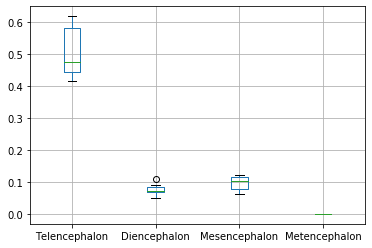

In [38]:
df_by_division.boxplot(widths=0.2)

In [40]:
# Now compare within batch among different conditions, for example:
# CNOnCrusILT, CNOnCrusIRT, lobVI_noreversal, Vehicleonly within the 202002_cfos batch
# That is super quick for one brain! Let's do this for all brains in the 202002 batch
def create_division_df(batch,condition):
    """ Given a batch and condition create a pandas DataFrame
    containing Brain, the major divisions, an Other category,
    the batch and condition for each brain in the dataframe in this batch and condition group"""
    batch_mask = main_df['experiment'] == batch
    condition_mask = main_df['Condition'] == condition
    comb_mask = np.logical_and(batch_mask,condition_mask)
    batch_df = main_df[comb_mask]
    batch_frac_counts_dict = {}
    for index,brain_series in batch_df.iterrows():
        brain = brain_series['Brain']
        batch_frac_counts_dict[brain] = {}
        for division in brain_division_dict:
            subregions = brain_division_dict[division]
            frac_counts = [get_fractional_counts(soi,brain_series) for soi in subregions]
            batch_frac_counts_dict[brain][division] = sum(frac_counts)
        remainder = 1-sum([batch_frac_counts_dict[brain][x] for x in batch_frac_counts_dict[brain].keys()])
        batch_frac_counts_dict[brain]['Other'] = remainder
    frac_counts_by_division = []
    for brain in batch_frac_counts_dict:
        division_dict = {'Brain':brain}
        for division in batch_frac_counts_dict[brain]:
            division_dict[division] = batch_frac_counts_dict[brain][division]
        frac_counts_by_division.append(division_dict)
    df = pd.DataFrame(frac_counts_by_division)
    df = df.assign(Batch=batch,Condition=condition)
    return df

In [34]:
df_by_division = create_division_df(batch="202002_cfos",condition="CNOnCrusILT")
df_by_division

,Brain,Telencephalon,Diencephalon,Mesencephalon,Metencephalon,Other,Batch,Condition
0,an15_crus1_left,0.439261,0.048268,0.121711,0.0,0.390761,202002_cfos,CNOnCrusILT
1,an16_crus1_left,0.618558,0.067842,0.073324,0.0,0.240276,202002_cfos,CNOnCrusILT
2,an17_crus1_left,0.556492,0.108636,0.061236,0.0,0.273636,202002_cfos,CNOnCrusILT
3,an1_crus1_left,0.490949,0.056755,0.116284,0.0,0.336012,202002_cfos,CNOnCrusILT
4,an2_crus1_lat,0.589017,0.086107,0.104520,0.0,0.220356,202002_cfos,CNOnCrusILT
5,an5_crus1_left,0.598310,0.072176,0.070991,0.0,0.258523,202002_cfos,CNOnCrusILT
6,an6_crus1_left,0.458946,0.075990,0.103347,0.0,0.361717,202002_cfos,CNOnCrusILT
7,an7_crus1_left,0.435870,0.091167,0.088841,0.0,0.384121,202002_cfos,CNOnCrusILT
8,an8_crus1_left,0.417131,0.074249,0.107812,0.0,0.400808,202002_cfos,CNOnCrusILT
9,an9_crus1_left,0.453735,0.070430,0.119675,0.0,0.356160,202002_cfos,CNOnCrusILT


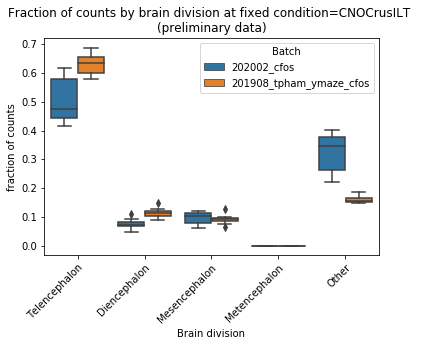

In [41]:
# Make a boxplot comparing fractional counts for brains subjected to the 
# same condition but from different batches
df_by_division = create_division_df(batch="202002_cfos",condition="CNOnCrusILT")
df_by_division_2019 = create_division_df(batch="201908_tpham_ymaze_cfos",condition="CNOnCrusILT")
# df_by_division_2019 = df_by_division_2019.assign(Batch="201908_tpham_ymaze_cfos")  
cdf = pd.concat([df_by_division, df_by_division_2019])   
# cdf

cdf.drop(['Brain','Condition'],axis=1,inplace=True)
mdf = pd.melt(cdf, id_vars=['Batch'], var_name=['Brain division'])
mdf.rename(columns={'value':'fraction of counts'},inplace=True)
mdf
ax = sns.boxplot(x="Brain division", y="fraction of counts", hue="Batch", data=mdf)  
ax.set_title("Fraction of counts by brain division at fixed condition=CNOCrusILT \n(preliminary data)")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.savefig('../cfos_fraccount_fixed_condition_prelim.png')

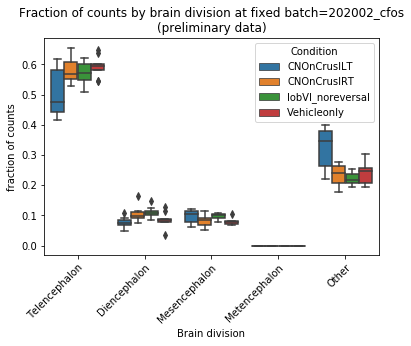

In [44]:
# Make a boxplot comparing fractional counts for brains  
# from the same batch but subjected to different conditions 
df_list = []
for condition in ['CNOnCrusILT','CNOnCrusIRT','lobVI_noreversal', 'Vehicleonly']:
    df = create_division_df(batch='202002_cfos',condition=condition)
    df_list.append(df)

cdf = pd.concat(df_list)   
# cdf
cdf.drop(['Brain','Batch'],axis=1,inplace=True)
mdf = pd.melt(cdf, id_vars=['Condition'], var_name=['Brain division'])
mdf.rename(columns={'value':'fraction of counts'},inplace=True)
ax = sns.boxplot(x="Brain division", y="fraction of counts", hue="Condition", data=mdf)  
ax.set_title("Fraction of counts by brain division at fixed batch=202002_cfos\n(preliminary data)")
_=plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.savefig('../figs/cfos_fraccount_fixed_batch_prelim.png')